In [ ]:
# package configurations needed for Google Colab and potentialy on local machine
# after running this block of code, restart the session

!pip uninstall -y scikit-plot scipy
!pip install scikit-plot scipy==1.11.4
!pip install --force-reinstall scikit-plot==0.3.7 scipy==1.11.4

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.0

In [42]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
warnings.filterwarnings('ignore')

## Load Dataset and Clean Dataset

In [3]:
# read the dataset
df = pd.read_csv("train.csv", sep = ",")
df_testing = pd.read_csv("test.csv", sep = ",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592380 entries, 0 to 592379
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    592380 non-null  int64  
 1   last_price            592380 non-null  float64
 2   mid                   592380 non-null  float64
 3   opened_position_qty   419920 non-null  float64
 4   closed_position_qty   419920 non-null  float64
 5   transacted_qty        592380 non-null  float64
 6   d_open_interest       592380 non-null  int64  
 7   bid1                  592380 non-null  float64
 8   bid2                  592380 non-null  float64
 9   bid3                  592380 non-null  float64
 10  bid4                  592380 non-null  float64
 11  bid5                  592380 non-null  float64
 12  ask1                  592380 non-null  float64
 13  ask2                  592380 non-null  float64
 14  ask3                  592380 non-null  float64
 15  

In [4]:
# drop the id column since it is just an index
df.drop(columns = ['id'], inplace = True)

# rename column name
df.rename(columns = {'opened_position_qty ': 'opened_position_qty'}, inplace = True)

# drop the id column since it is just an index
df_testing.drop(columns = ['id'], inplace = True)

# rename column name
df_testing.rename(columns = {'opened_position_qty ': 'opened_position_qty'}, inplace = True)

In [5]:
# check for missing data
df.isnull().sum()

last_price                  0
mid                         0
opened_position_qty    172460
closed_position_qty    172460
transacted_qty              0
d_open_interest             0
bid1                        0
bid2                        0
bid3                        0
bid4                        0
bid5                        0
ask1                        0
ask2                        0
ask3                        0
ask4                        0
ask5                        0
bid1vol                     0
bid2vol                     0
bid3vol                     0
bid4vol                     0
bid5vol                     0
ask1vol                     0
ask2vol                     0
ask3vol                     0
ask4vol                     0
ask5vol                     0
y                           0
dtype: int64

In [6]:
# check for missing data
df_testing.isnull().sum()

last_price                 0
mid                        0
opened_position_qty    53656
closed_position_qty    53656
transacted_qty             0
d_open_interest            0
bid1                       0
bid2                       0
bid3                       0
bid4                       0
bid5                       0
ask1                       0
ask2                       0
ask3                       0
ask4                       0
ask5                       0
bid1vol                    0
bid2vol                    0
bid3vol                    0
bid4vol                    0
bid5vol                    0
ask1vol                    0
ask2vol                    0
ask3vol                    0
ask4vol                    0
ask5vol                    0
dtype: int64

In [7]:
# replace data points based on surrounding data values
# linear assumes a 'straight line' from the previous data points to the next one. may be less accurate if we have a bunch of missing data points in a row
df['opened_position_qty'].interpolate(method='linear', inplace=True)
df['closed_position_qty'].interpolate(method='linear', inplace=True)

df_testing['opened_position_qty'].interpolate(method='linear', inplace=True)
df_testing['closed_position_qty'].interpolate(method='linear', inplace=True)

In [8]:
# check for missing data
df.isnull().sum()

last_price             0
mid                    0
opened_position_qty    1
closed_position_qty    1
transacted_qty         0
d_open_interest        0
bid1                   0
bid2                   0
bid3                   0
bid4                   0
bid5                   0
ask1                   0
ask2                   0
ask3                   0
ask4                   0
ask5                   0
bid1vol                0
bid2vol                0
bid3vol                0
bid4vol                0
bid5vol                0
ask1vol                0
ask2vol                0
ask3vol                0
ask4vol                0
ask5vol                0
y                      0
dtype: int64

In [9]:
# check for missing data
df_testing.isnull().sum()

last_price             0
mid                    0
opened_position_qty    0
closed_position_qty    0
transacted_qty         0
d_open_interest        0
bid1                   0
bid2                   0
bid3                   0
bid4                   0
bid5                   0
ask1                   0
ask2                   0
ask3                   0
ask4                   0
ask5                   0
bid1vol                0
bid2vol                0
bid3vol                0
bid4vol                0
bid5vol                0
ask1vol                0
ask2vol                0
ask3vol                0
ask4vol                0
ask5vol                0
dtype: int64

In [10]:
df.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,3841.0,...,1,6,14,6,6,1,1,10,2,1
1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,6,11,1,6,1,4,4,1,13,0
2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,1,4,21,12,1,16,10,4,9,0
3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,13,12,2,4,2,7,1,2,11,1
4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,12,2,2,4,1,3,1,11,15,1


In [11]:
# remove the first row which is the only one with missing data now
df = df.iloc[1:]

## Feature Engineering

In [12]:
# Feature Engineering with midprice and Open/Close positions

# Feature: Ratio of opened_position_qty to closed_position_qty
df['open_close_ratio'] = df['opened_position_qty'] / (df['closed_position_qty'] + 1e-6)  # Add small value to avoid division by zero
df_testing['open_close_ratio'] = df['opened_position_qty'] / (df['closed_position_qty'] + 1e-6)  # Add small value to avoid division by zero

# Feature: Difference between midprice and last price
df['mid_last_diff'] = df['mid'] - df['last_price']
df_testing['mid_last_diff'] = df['mid'] - df['last_price']

# Feature: Total bid volume compared to midprice
total_bid_vol = df['bid1vol'] + df['bid2vol'] + df['bid3vol'] + df['bid4vol'] + df['bid5vol']
total_ask_vol = df['ask1vol'] + df['ask2vol'] + df['ask3vol'] + df['ask4vol'] + df['ask5vol']

total_bid_vol_testing = df_testing['bid1vol'] + df_testing['bid2vol'] + df_testing['bid3vol'] + df_testing['bid4vol'] + df_testing['bid5vol']
total_ask_vol_testing = df_testing['ask1vol'] + df_testing['ask2vol'] + df_testing['ask3vol'] + df_testing['ask4vol'] + df_testing['ask5vol']

# ratio between bid/ask volume and the midprice:
df['bid_ask_vol_ratio'] = total_bid_vol / (total_ask_vol + 1e-6)  # Add small value to avoid division by zero
df_testing['bid_ask_vol_ratio'] = total_bid_vol_testing / (total_ask_vol_testing + 1e-6)  # Add small value to avoid division by zero

In [13]:
# export the last 50,000 rows from training data
trainingSubSet = df.tail(50000)
trainingSubSet.to_csv("training_subset.csv", index = False)
del trainingSubSet

# drop the last 50,000 rows
df = df.iloc[:-50000]

## Preview Clean Data

In [14]:
df.describe()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
count,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,...,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,5.423790e+05,542379.000000,542379.000000
mean,3954.533795,3954.533236,1.226652,1.760391,2.368866,-0.095653,3954.342101,3954.105260,3953.882489,3953.662123,...,6.026555,3.901796,4.948324,5.360373,5.669381,5.994170,0.354608,2.215201e+05,-0.000559,1.300719
std,76.290754,76.290037,1.974799,2.317897,3.776659,2.348708,76.285531,76.280009,76.274652,76.268426,...,6.312679,4.505113,5.455593,5.951042,6.511757,6.991134,0.478395,7.365535e+05,0.210798,1.026004
min,3812.000000,3812.100000,0.000000,0.000000,0.000000,-171.000000,3811.800000,3811.600000,3811.400000,3811.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,-2.000000,0.042857
25%,3894.600000,3894.700000,0.000000,1.000000,0.000000,-1.000000,3894.400000,3894.200000,3894.000000,3893.800000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000e+00,-0.100000,0.625000
50%,3970.000000,3970.000000,1.000000,1.000000,1.000000,0.000000,3969.800000,3969.600000,3969.400000,3969.200000,...,4.000000,2.000000,3.000000,4.000000,4.000000,4.000000,0.000000,4.999998e-01,0.000000,1.000000
75%,4024.800000,4024.700000,1.500000,2.000000,3.000000,1.000000,4024.600000,4024.200000,4024.000000,4023.800000,...,8.000000,5.000000,6.000000,7.000000,7.000000,7.000000,1.000000,1.999996e+00,0.100000,1.647059
max,4082.800000,4082.900000,80.000000,212.000000,311.000000,50.000000,4082.800000,4082.600000,4082.400000,4082.200000,...,120.000000,130.000000,132.000000,133.000000,134.000000,135.000000,1.000000,2.400000e+07,2.600000,22.249997


In [15]:
df.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,6,1,4,4,1,13,0,0.122449,0.6,1.347826
2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,12,1,16,10,4,9,0,0.090909,0.3,1.025000
3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,4,2,7,1,2,11,1,0.088235,-0.4,1.782609
4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,4,1,3,1,11,15,1,0.078947,-0.1,1.096774
5,3843.6,3844.2,12.0,17.0,29.0,-5,3843.8,3843.4,3843.2,3843.0,...,17,1,12,15,10,3,0,0.705882,0.6,0.658537


In [16]:
df.tail()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
542375,4044.2,4044.2,0.5,1.5,0.0,0,4044.0,4043.8,4043.4,4043.2,...,4,2,3,2,1,1,1,0.333333,0.0,1.888889
542376,4044.4,4044.2,1.0,1.0,2.0,0,4044.0,4043.8,4043.4,4043.2,...,4,1,3,1,22,1,0,0.999999,-0.2,0.607143
542377,4044.4,4044.4,3.0,2.0,5.0,1,4044.2,4043.8,4043.4,4043.2,...,4,3,1,22,1,2,0,1.499999,0.0,0.448276
542378,4044.4,4044.2,0.0,9.0,9.0,-8,4043.8,4043.4,4043.2,4043.0,...,3,3,1,22,1,2,0,0.000000,-0.2,0.517241
542379,4044.4,4044.2,0.5,5.5,0.0,0,4044.0,4043.8,4043.4,4043.2,...,4,1,3,1,22,1,0,0.090909,-0.2,0.500000


## Split the Dataset for Training and Testing

In [17]:
# predictors
X = df.drop(columns = ['y'])

# response variable
y = df['y']

# spilt the dataset into training and testing with a 80/20 spilt with a random state
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.2, random_state = 123)

## Random Forest Model

### Fitting a Random Forest

Note that it takes at least 90 minutes in Google Colab in a standard runtime for the Random Forest to compile.



In [39]:
# parameters for hypertuning
parameters = [{'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [7, 9, 12, 16],
               'criterion': ['gini', 'entropy']}]

# hypertune for random froest
GridSearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), param_grid = parameters, scoring = 'accuracy', cv = 5)

# fit a random forest
GridSearch_RandomForest.fit(X_train, y_train)
print(GridSearch_RandomForest.best_params_)

# score for the best model
print(GridSearch_RandomForest.score(X_train, y_train))


{'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100}
0.7593448305266385


In [68]:
# save the random forest model
pickle.dump(GridSearch_RandomForest, open("Random_Forest.sav", "wb"))

### Predicted Data from Random Forest

In [48]:
prediction_RandomForest = GridSearch_RandomForest.predict(X_test)
print(prediction_RandomForest)
prediction_probs_RandomForest = GridSearch_RandomForest.predict_proba(X_test)
print(prediction_probs_RandomForest)

[0 0 0 ... 0 0 0]
[[0.65002626 0.34997374]
 [0.62779504 0.37220496]
 [0.56515019 0.43484981]
 ...
 [0.50132763 0.49867237]
 [0.8253544  0.1746456 ]
 [0.62774089 0.37225911]]


In [17]:
print('Accuracy: ', accuracy_score(y_test, prediction_RandomForest))

Accuracy:  0.6670968693535897


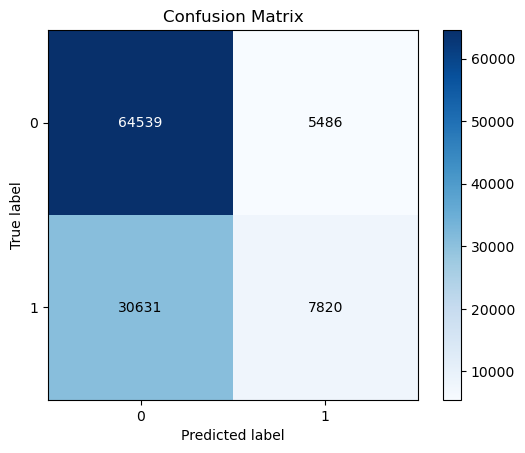

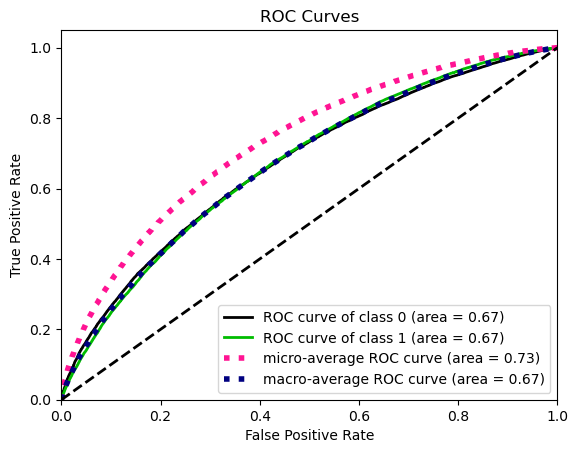

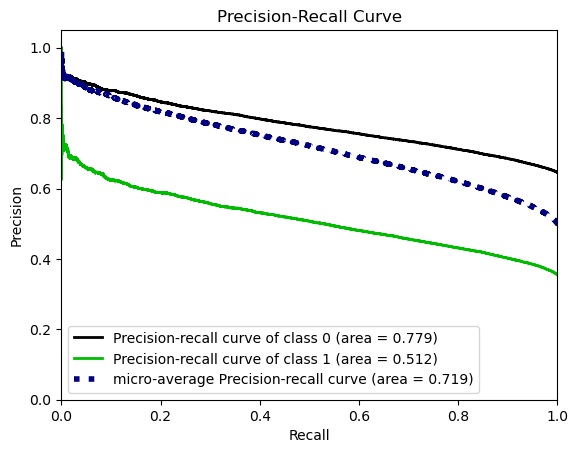

In [49]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_RandomForest)
skplt.metrics.plot_roc(y_test, prediction_probs_RandomForest)
skplt.metrics.plot_precision_recall_curve(y_test, prediction_probs_RandomForest)
plt.show()

## Support Vector Machine

In [40]:
# reduce the predictors to only consider open_close_ratio, mid_last_diff, and bid_ask_vol_ratio
X_train_reduced = X_train[['open_close_ratio', 'mid_last_diff', 'bid_ask_vol_ratio']]
X_test_reduced = X_test[['open_close_ratio', 'mid_last_diff', 'bid_ask_vol_ratio']]

# scale the predictors
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.fit_transform(X_test_reduced)

### Fitting a SVM Model

Note that SVM takes at least 5 hours.

In [41]:
# fit a svm
svm_model = SVC(kernel='linear', class_weight='balanced', probability = True)
svm_model.fit(X_train_reduced_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True)

In [54]:
# Get the feature importance (coefficients) for each feature
feature_importance = svm_model.coef_[0]

# Print feature importance values alongside feature names
features = df.columns[:-1]  # Exclude the label column
for feature, importance in zip(features, feature_importance):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: last_price, Importance: -0.016752176603468845
Feature: mid, Importance: -0.5742603116602777
Feature: opened_position_qty, Importance: 0.33642709897851125


In [69]:
# save the SVM model
pickle.dump(svm_model, open("SVM.sav", "wb"))

### Predicted Data from SVM

Note that this takes about 14 minutes.

In [50]:
prediction_SVM = svm_model.predict(X_test_reduced_scaled)
print(prediction_SVM)
prediction_probs_SVM = svm_model.predict_proba(X_test_reduced_scaled)
print(prediction_probs_SVM)

[0 1 0 ... 1 0 1]
[[0.704179   0.295821  ]
 [0.5896563  0.4103437 ]
 [0.7216936  0.2783064 ]
 ...
 [0.51326713 0.48673287]
 [0.76500716 0.23499284]
 [0.62382636 0.37617364]]


In [51]:
print('Accuracy: ', accuracy_score(y_test, prediction_SVM))

Accuracy:  0.5795475496884104


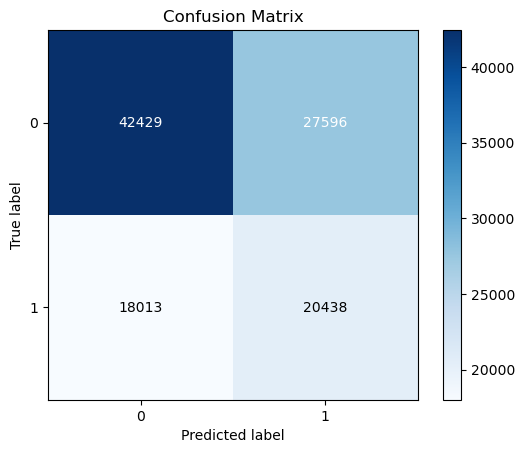

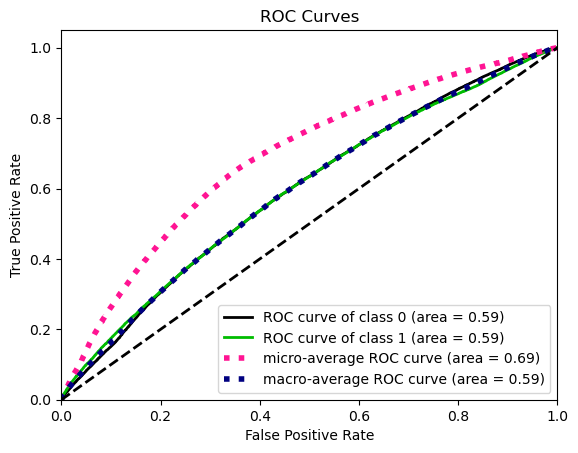

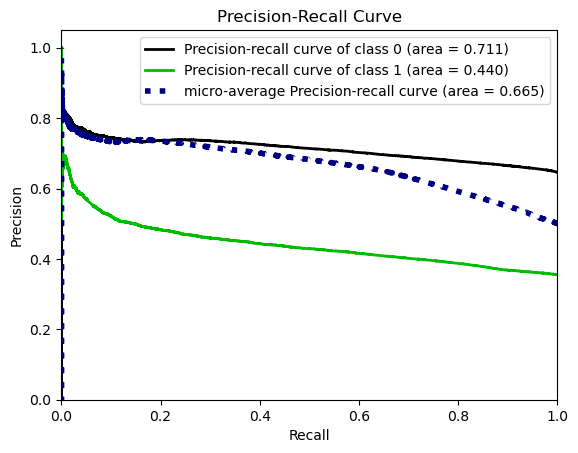

In [52]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_SVM)
skplt.metrics.plot_roc(y_test, prediction_probs_SVM)
skplt.metrics.plot_precision_recall_curve(y_test, prediction_probs_SVM)
plt.show()

## Long Short-Term Memory Model

In [21]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# using numPy to reshape data. LSTM requires 3D data - samples (individual data points(rows)), time steps (length of time step used to predict target var), features (predictor columns used for making predictions)
# default of 1 time step, might set this to 10 or something.
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# assuming the data has been scaled and reshaped properly
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, 29))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, 29))

### Fitting LTSM Model

In [28]:
# build LSTM
LSTM_model = Sequential()

# adding first layer. Dropout sets a # of neurons to zero during training to prevent overreliance on certain patterns. (overfitting)
# "X_train.shape[1], X_train.shape[2]" selects the time steps and the # features as the 'input shape' so the model knows what data it's getting
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 29)))

# Add Dropout to prevent overfitting
LSTM_model.add(Dropout(0.1))

# second layer, adds 50 more neurons
LSTM_model.add(LSTM(units=50, return_sequences=False))
LSTM_model.add(Dropout(0.1))

# output layer
LSTM_model.add(Dense(units=1, activation='sigmoid'))

# compiles model w selected features. The optimizer is how the model updates weights using backpropagation calc and is (variant of SGD - stochastic gradient descent) - loss function tells optimizer how far guesses were off.
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

# train the model
LSTM_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/20
13560/13560 [==============================] - 18s 1ms/step - loss: 0.6280 - auc: 0.6266 - val_loss: 0.6200 - val_auc: 0.6468
Epoch 2/20
13560/13560 [==============================] - 17s 1ms/step - loss: 0.6212 - auc: 0.6427 - val_loss: 0.6193 - val_auc: 0.6505
Epoch 3/20
13560/13560 [==============================] - 16s 1ms/step - loss: 0.6202 - auc: 0.6451 - val_loss: 0.6174 - val_auc: 0.6513
Epoch 4/20
13560/13560 [==============================] - 16s 1ms/step - loss: 0.6197 - auc: 0.6462 - val_loss: 0.6188 - val_auc: 0.6511
Epoch 5/20
13560/13560 [==============================] - 16s 1ms/step - loss: 0.6192 - auc: 0.6470 - val_loss: 0.6188 - val_auc: 0.6514
Epoch 6/20
13560/13560 [==============================] - 16s 1ms/step - loss: 0.6188 - auc: 0.6481 - val_loss: 0.6172 - val_auc: 0.6516
Epoch 7/20
13560/13560 [==============================] - 17s 1ms/step - loss: 0.6187 - auc: 0.6482 - val_loss: 0.6174 - val_auc: 0.6516
Epoch 8/20
13560/13560 [=================

### Predicted Data from LTSM

In [35]:
prediction_probs_LTSM = LSTM_model.predict(X_test_scaled)
prediction_LTSM = prediction_probs_LTSM
prediction_LTSM[prediction_LTSM < .5] = 0
prediction_LTSM[prediction_LTSM >= .5] = 1
print(prediction_LTSM)

3390/3390 [==============================] - 1s 368us/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [33]:
# Evaluate the model on test data
test_loss, test_auc = LSTM_model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")

3390/3390 [==============================] - 2s 467us/step - loss: 0.6152 - auc: 0.6562
Test Loss: 0.6151808500289917
Test AUC: 0.6562079191207886


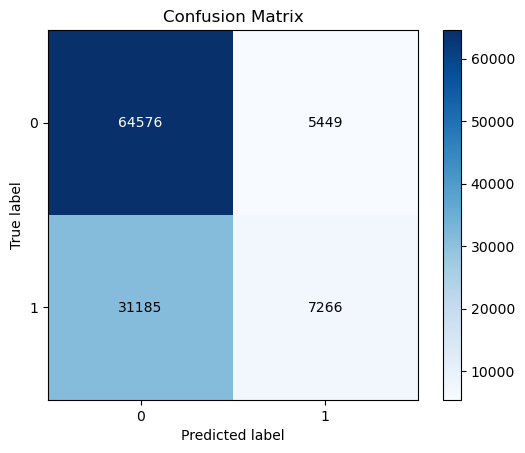

In [38]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_LTSM)
plt.show()

## Predicting a Random Sample from Testing File

In [59]:
randomTestingDataSample = df_testing.sample(n = 1, random_state = 123)
randomTestingDataSample

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
7951,5194.0,5194.3,1.0,0.0,1.0,1,5194.0,5193.8,5193.2,5192.0,...,1,5,1,2,2,1,1,0.0,-0.2,2.285714


### Random Forest
Random Forest is the only one considered since that model performed the best.

In [60]:
prediction_testing_RandomForest = GridSearch_RandomForest.predict(randomTestingDataSample)
print(prediction_testing_RandomForest)

[0]
